I guess autograd is magic. Now our goal is to try to optimize this algorithm to match embcom times (or at least within the same order of magnitude). Currently, the algorithm takes 18 mins to embed an 1000 node lfr network. This is far from ideal :'(

What are the 

In [1]:
import time
import random
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import lfr
import sys
import cProfile, pstats

In [8]:
##############################################
# Block 1: Setup and Random Walk Generation  #
##############################################

def generate_random_walks(G, num_walks=10, walk_length=10):
    """
    Generate random walks over the graph G.
    Note: For larger graphs, consider using more efficient vectorized implementations or libraries like 
    StellarGraph which implement efficient random walk sampling.
    """
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            for i in range(walk_length - 1):
                cur = walk[-1]
                neighbors = list(G.neighbors(cur))
                if len(neighbors) == 0:
                    break
                walk.append(random.choice(neighbors))
            walks.append(walk)
    return walks

##############################################
# Block 2: Generating SkipGram Pairs         #
##############################################

def generate_skipgram_pairs(walks, window_size=2):
    """
    For each walk, generate (center, context) pairs using a sliding window.
    Consider profiling this block using line_profiler if walks or window_size are large.
    """
    pairs = []
    for walk in walks:
        L = len(walk)
        for i, center in enumerate(walk):
            start = max(0, i - window_size)
            end = min(L, i + window_size + 1)
            for j in range(start, end):
                if i == j:
                    continue
                pairs.append((center, walk[j]))
    return pairs

##############################################
# Block 3: Dataset and DataLoader            #
##############################################

class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        return center, context

##############################################
# Block 4: SkipGram Model and Loss Function    #
##############################################

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, sim_type="dot"):
        """
        Parameters:
          vocab_size: int – number of nodes.
          embedding_dim: int – embedding dimensionality.
          sim_type: str – similarity measure; options: "dot", "euclidean", "cosine".
        """
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.sim_type = sim_type.lower()
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        initrange = 0.5 / embedding_dim
        self.center_embeddings.weight.data.uniform_(-initrange, initrange)
        self.context_embeddings.weight.data.zero_()
        self.beta = nn.Parameter(torch.tensor(1.0))  # Scaling factor for Euclidean distances

    def forward(self, center_idxs, context_idxs, negative_idxs):
        """
        center_idxs: (B,) tensor for center nodes.
        context_idxs: (B,) tensor for positive context nodes.
        negative_idxs: (B, K) tensor for negative samples.
        Returns:
          pos_scores: (B,) tensor of scores for positive pairs.
          neg_scores: (B, K) tensor of scores for negative pairs.
        """
        center_vecs = self.center_embeddings(center_idxs)         # (B, D)
        pos_context_vecs = self.context_embeddings(context_idxs)    # (B, D)
        neg_context_vecs = self.context_embeddings(negative_idxs)   # (B, K, D)
        
        # Compute positive pair scores based on similarity type.
        if self.sim_type == "dot":
            pos_scores = torch.sum(center_vecs * pos_context_vecs, dim=1)
        elif self.sim_type == "euclidean":
            pos_scores = -torch.norm(center_vecs - pos_context_vecs, dim=1) * self.beta
        elif self.sim_type == "cosine":
            pos_scores = F.cosine_similarity(center_vecs, pos_context_vecs, dim=1)
        else:
            raise ValueError("Unknown similarity type. Choose from 'dot', 'euclidean', or 'cosine'.")

        # Compute negative pair scores.
        if self.sim_type == "dot":
            neg_scores = torch.bmm(neg_context_vecs, center_vecs.unsqueeze(2)).squeeze(2)  # (B, K)
        elif self.sim_type == "euclidean":
            neg_scores = -torch.norm(center_vecs.unsqueeze(1) - neg_context_vecs, dim=2)  # (B, K)
        elif self.sim_type == "cosine":
            neg_scores = F.cosine_similarity(center_vecs.unsqueeze(1).expand_as(neg_context_vecs), neg_context_vecs, dim=2)
        return pos_scores, neg_scores

def skipgram_loss(pos_scores, neg_scores):
    """
    Compute loss:
      - For a positive pair: L_pos = -log(sigmoid(score))
      - For negative samples: L_neg = -sum(log(sigmoid(-score)))
    Optimization tip: You can use F.logsigmoid for numerical stability.
    """
    loss_pos = -F.logsigmoid(pos_scores)
    loss_neg = -torch.sum(F.logsigmoid(-neg_scores), dim=1)
    loss = loss_pos + loss_neg
    return loss.mean()

##############################################
# Block 5: Training Loop                     #
##############################################

def train_model(G, num_walks = 10, walk_length = 80, 
                window_size = 10, embedding_dim = 128, 
                negative_samples = 5, num_epochs = 1, sim_type = "dot"):
    # Options: "dot", "euclidean", "cosine"
    
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

   
   
    
    # Generate random walks
    start_time = time.time()
    walks = generate_random_walks(G, num_walks, walk_length)
    print("Number of walks:", len(walks))
    print("Example walk:", walks[0])



    pairs = generate_skipgram_pairs(walks, window_size)
    print("Number of positive pairs:", len(pairs))
    print("Example pairs:", pairs[:5])
    print("Skipgram walks and pairs generated in {:.4f} seconds.".format(time.time() - start_time))

    # Create dataset and dataloader
    dataset = SkipGramDataset(pairs)
    # For larger datasets, consider setting num_workers > 0 for parallel data loading.
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

    

    # Hyperparameters
    vocab_size = G.number_of_nodes()   # Assuming node IDs are 0-indexed.
    

    # Initialize model and optimizer
    model = SkipGramModel(vocab_size, embedding_dim, sim_type=sim_type).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("\nStarting training...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_start = time.time()
        for center_idxs, context_idxs in dataloader:
            center_idxs = center_idxs.to(device)
            context_idxs = context_idxs.to(device)
            batch_size = center_idxs.size(0)
            # Use device variable to ensure compatibility even if the device is CPU.
            negative_idxs = torch.randint(0, vocab_size, (batch_size, negative_samples), device=device)
            optimizer.zero_grad()
            pos_scores, neg_scores = model(center_idxs, context_idxs, negative_idxs)
            loss = skipgram_loss(pos_scores, neg_scores)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size
        avg_loss = epoch_loss / len(dataset)
        print(f"Epoch {epoch+1}/{num_epochs} completed in {time.time() - epoch_start:.2f}s, Loss: {avg_loss:.4f}")

    # Save or return the trained model and embeddings as needed.
    return model, device

##############################################
# Block 6: Evaluating and Extracting         #
#         Embeddings                         #
##############################################

def evaluate_model(model, device):
    model.eval()
    with torch.no_grad():
        embeddings = model.center_embeddings.weight.cpu().numpy()
    print("Embeddings shape:", embeddings.shape)
    # print("First 5 embeddings:")
    # print(embeddings[:5])
    return embeddings

In [ ]:
##############################################
# Main Function: Run the Training and Eval   #
##############################################

import lfr
def create_network(params={
    "N": 1000,     # number of nodes
    "k": 6,        # average degree
    "maxk": 25,    # maximum degree
    "minc": 25,    # minimum community size
    "maxc": 250,   # maximum community size
    "tau": 2,      # degree exponent
    "tau2": 1.5,   # community size exponent
    "mu": 0.01,     # mixing rate
}):
    ng = lfr.NetworkGenerator()
    data = ng.generate(**params)
    net = data["net"]                  # scipy.csr_sparse matrix
    community_table = data["community_table"]  # pandas DataFrame
    seed = data["seed"]                # Seed value
    return net, community_table, seed


# Create a sample graph (Karate Club)
#G = nx.karate_club_graph()
# Generate the network and the associated community table
A, community_labels, _ = create_network()
G = nx.from_scipy_sparse_array(A)

#profiler = cProfile.Profile()
#profiler.enable()
model, device = train_model(G, num_walks = 10, walk_length = 80, 
                            window_size = 10, embedding_dim = 128, 
                            negative_samples = 5, num_epochs = 1, sim_type = "euclidean" )

embeddings = evaluate_model(model, device)

#profiler.disable()

Using device: cuda
Number of walks: 10000
Example walk: [742, 881, 117, 822, 902, 860, 41, 822, 617, 742, 515, 822, 515, 822, 471, 822, 139, 822, 833, 644, 452, 607, 452, 607, 695, 684, 617, 684, 881, 117, 822, 833, 650, 833, 515, 742, 515, 833, 457, 742, 665, 607, 860, 695, 684, 860, 349, 860, 452, 860, 684, 902, 374, 617, 822, 471, 860, 695, 275, 644, 829, 695, 860, 867, 107, 867, 107, 79, 743, 79, 329, 46, 329, 79, 743, 835, 980, 516, 980, 835]
Number of positive pairs: 14900000
Example pairs: [(742, 881), (742, 117), (742, 822), (742, 902), (742, 860)]
Skipgram walks and pairs generated in 4.1549 seconds.

Starting training...


In [13]:
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

         319744 function calls (311175 primitive calls) in 1.718 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      362    0.503    0.001    0.503    0.001 {method 'run_backward' of 'torch._C._EngineBase' objects}
      362    0.095    0.000    0.260    0.001 /tmp/ipykernel_1786143/3114267137.py:85(forward)
     1086    0.069    0.000    0.069    0.000 {built-in method torch.embedding}
      362    0.057    0.000    0.128    0.000 /tmp/ipykernel_1786143/3114267137.py:117(skipgram_loss)
     1090    0.051    0.000    0.051    0.000 {built-in method torch.tensor}
      724    0.049    0.000    0.049    0.000 {built-in method torch._C._linalg.linalg_vector_norm}
      727    0.039    0.000    0.039    0.000 {method 'to' of 'torch._C.TensorBase' objects}
     1088    0.037    0.000    0.037    0.000 {built-in method torch._ops.profiler._record_function_enter_new}
      724    0.034    0.000    0.034    0.000 {built-in method

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


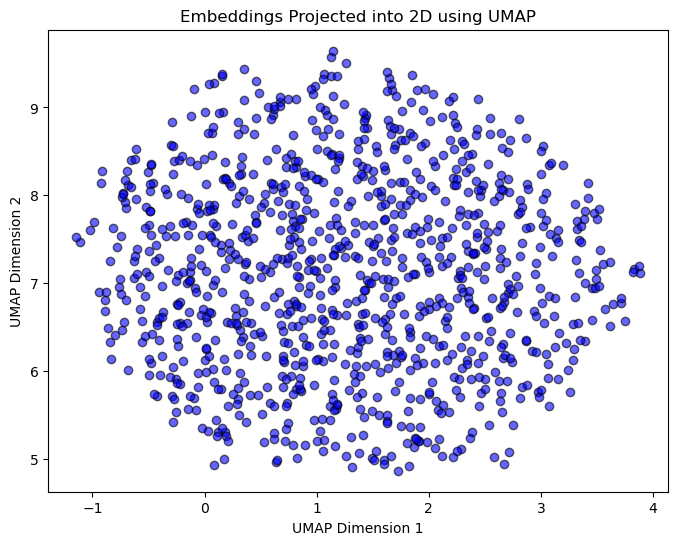

In [23]:
import tqdm
import matplotlib.pyplot as plt
import umap 

# Apply UMAP to reduce dimensionality to 2D
umap_reducer = umap.UMAP(n_components=2)
embeddings_2d = umap_reducer.fit_transform(embeddings)

# Plot the embeddings in 2D
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.6, edgecolors='k')
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Embeddings Projected into 2D using UMAP")
plt.show()

In [3]:
!{sys.executable} -m pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 40.8 MB/s eta 0:00:000m eta 0:00:010:01


In [15]:
import embcom


def create_embedding(G, emb_params = {
                                            "window_length": 10,
                                            "walk_length": 80,
                                            "num_walks": 10,
                                            "dim" : 128,
                                        }):
  
    model = embcom.embeddings.Node2Vec(window_length = emb_params['window_length'], walk_length=emb_params['walk_length'], num_walks=emb_params['num_walks'])
            
    net = nx.adjacency_matrix(G).astype(float)
    model.fit(net)
    emb = model.transform(dim=emb_params['dim'])

    return emb

G = nx.karate_club_graph()

start_t = time.time()
emb_p = create_embedding(G)
print(time.time() - start_t)

0.046953678131103516


In [25]:
from sklearn.metrics.pairwise import cosine_similarity


def calculate_normalized_embedding_loss(V_a, V_b):
    
    
    def center_embeddings(V):
        # Subtract the mean of each column from the corresponding entries
        return V - np.mean(V, axis=0)

    
    # Step 1: Center both embedding matrices
    V_a_centered = center_embeddings(V_a)
    V_b_centered = center_embeddings(V_b)
    
    # Step 2: Calculate cosine similarity matrices for centered embeddings
    C_a = cosine_similarity(V_a_centered)
    C_b = cosine_similarity(V_b_centered)
    
    # Step 3: Calculate the absolute differences between cosine similarities
    N = V_a.shape[0]
    loss = 0
    
    # Only sum over the upper triangular part of the matrix (i < j)
    for i in range(N):
        for j in range(i+1, N):
            loss += np.abs(C_a[i, j] - C_b[i, j])
    
    # Step 4: Normalize the loss
    normalized_loss = (2 / (N * (N - 1))) * loss
    
    return normalized_loss



loss = calculate_normalized_embedding_loss(emb_p, embeddings)
loss

0.12090663118823636